<a href="https://colab.research.google.com/github/dookda/cmu_water_balance/blob/main/watbalance_multisource_sltm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
# ใน Google Colab ต้องใช้ ee.Authenticate() แทน earthengine authenticate เพราะ Colab ไม่มี CLI เหมือนเครื่อง Local
ee.Authenticate()

# 1. Initialize the session
ee.Initialize(project="ee-sakda-451407")

In [4]:
import pandas as pd

# 2. Define region, dates
basin = ee.FeatureCollection('projects/ee-sakda-451407/assets/nan_extent')
start, end = '2020-01-01', '2022-12-31'

# 3. Load collections
precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
           .filterDate(start, end) \
           .filterBounds(basin)
et8d   = ee.ImageCollection('MODIS/006/MOD16A2') \
           .filterDate(start, end) \
           .filterBounds(basin) \
           .map(lambda img: img.divide(8).copyProperties(img, ['system:time_start']))
sm     = ee.ImageCollection('NASA/SMAP/SPL3SMP_E/005') \
           .filterDate(start, end) \
           .filterBounds(basin)

# 4. Function to turn ImageCollection into a list of Features with date + value
def ts(ic, band, name):
    def toFeature(img):
        mean_dict = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=basin.geometry(),
            scale=10000,
            maxPixels=1e13
        )
        return ee.Feature(None, {
            'date': img.date().format('YYYY-MM-dd'),
            name: mean_dict.get(band)
        })
    return ic.map(toFeature)

p_ts = ts(precip, 'precipitation', 'P')
e_ts = ts(et8d,   'ET',            'ET')
s_ts = ts(sm,     'soil_moisture_am', 'SM')

# print(p_ts.getInfo())
# print(e_ts.getInfo())
# print(s_ts.getInfo())

# 5. Fetch to client
def fc_to_df(fc):
    features = fc.getInfo()['features']
    data = [f['properties'] for f in features]
    return pd.DataFrame(data)

df_p  = fc_to_df(p_ts)
df_et = fc_to_df(e_ts)
df_sm = fc_to_df(s_ts)

# 6. Merge on date
df = df_p.merge(df_et, on='date').merge(df_sm, on='date')
df['date'] = pd.to_datetime(df['date'])

# print(df_p)
# print(df_et)
# print(df_sm)
# print(df)

# 7. (Optional) Compute ΔSM and runoff proxy R = P – ET – ΔSM
df['dSM'] = df['SM'].diff().fillna(0)
df['R']   = df['P'] - df['ET'] - df['dSM']

# 8. Inspect
print(df.head())

# 9. Save locally
df.to_csv('basin_water_balance_ts.csv', index=False)

In [19]:
import ee
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. INITIALIZE AND PULL DATA FROM GEE
# define basin geometry (replace with your asset or GeoJSON)
basin = ee.FeatureCollection('projects/ee-sakda-451407/assets/nan_extent')
start, end = '2020-01-01', '2022-12-31'

def get_ts(col_id, band, name, scale=10000, agg_factor=1):
    ic = ee.ImageCollection(col_id) \
            .filterDate(start, end) \
            .filterBounds(basin)
    if agg_factor != 1:
        # for e.g. MODIS 8-day ET to daily
        ic = ic.map(lambda img: img.select(band).divide(agg_factor)
                                .copyProperties(img, ['system:time_start']))
    def to_feature(img):
        mean = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=basin.geometry(),
            scale=scale,
            maxPixels=1e13
        )
        return ee.Feature(None, {
            'date': img.date().format('YYYY-MM-dd'),
            name: mean.get(band)
        })
    return ic.map(to_feature)

# precipitation
p_fc  = get_ts('UCSB-CHG/CHIRPS/DAILY', 'precipitation', 'P', scale=5000)
# evapotranspiration (MOD16A2 is 8-day total ET)
et_fc = get_ts('MODIS/006/MOD16A2', 'ET', 'ET', scale=500, agg_factor=8)
# soil moisture
sm_fc = get_ts('NASA/SMAP/SPL3SMP_E/005', 'soil_moisture_am', 'SM', scale=10000)




In [22]:
# convert FusionTables to Pandas
def fc_to_df(fc):
    feats = fc.getInfo()['features']
    props = [f['properties'] for f in feats]
    return pd.DataFrame(props)

df = (
    fc_to_df(p_fc)
      .merge(fc_to_df(et_fc), on='date')
      .merge(fc_to_df(sm_fc), on='date')
)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# compute ΔSM and runoff proxy R = P - ET - ΔSM
df['dSM'] = df['SM'].diff().fillna(0)
df['R']   = df['P'] - df['ET'] - df['dSM']

# keep only numeric features + target (e.g. predict R)
features = ['P','ET','dSM']
target   = 'R'
data = df[features + [target]].values

print(data)

[[ 5.60029206e-01  3.22364689e+01  0.00000000e+00 -3.16764397e+01]
 [ 1.19055402e-01  2.50005275e+01  2.83197828e-03 -2.48843041e+01]
 [ 1.43579523e-02  2.34073861e+01 -2.52776658e-02 -2.33677505e+01]
 [ 1.59464010e-03  2.21442726e+01  2.81662036e-02 -2.21708442e+01]
 [ 0.00000000e+00  2.20602897e+01 -4.62588121e-02 -2.20140309e+01]
 [ 2.37611094e-02  2.26852560e+01 -1.21453686e-04 -2.26613734e+01]
 [ 1.83302184e-01  2.08569800e+01 -1.28345088e-02 -2.06608433e+01]
 [ 1.72334154e-02  1.90313472e+01  2.34080241e-03 -1.90164546e+01]
 [ 6.01022687e-02  2.11605509e+01  1.26937533e-01 -2.12273862e+01]
 [ 0.00000000e+00  1.67342685e+01 -1.21002556e-01 -1.66132659e+01]
 [ 4.91743975e-02  1.68524282e+01  3.43137892e-02 -1.68375676e+01]
 [ 3.48593718e-01  1.55765825e+01 -5.42406860e-02 -1.51737481e+01]
 [ 8.58780750e-02  1.57074552e+01  1.57195058e-02 -1.56372966e+01]
 [ 1.72512725e-03  1.89646502e+01  9.00113023e-02 -1.90529364e+01]
 [ 1.56379048e+01  2.31545263e+01 -1.60071296e-03 -7.51502078e

In [28]:
# 2. SCALE AND SEQUENCE
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# create sequences
sequence_length = 30  # use last 30 days to predict next-day runoff
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i+sequence_length, :-1])  # all features
    y.append(data_scaled[i+sequence_length, -1])     # target column
X, y = np.array(X), np.array(y)

# train/val/test split (70/15/15)
n = len(X)
train_end = int(n*0.7)
val_end   = int(n*0.85)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]



In [29]:
# 3. BUILD & TRAIN MULTIVARIATE LSTM 1
model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(sequence_length, 1)))
model.add(LSTM(32, activation='tanh', dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# ฝึกโมเดล
model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 3 and 1 for '{{node sequential_3_1/lstm_6_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_3_1/lstm_6_1/lstm_cell_1/mul, sequential_3_1/lstm_6_1/lstm_cell_1/split)' with input shapes: [?,3], [1,64].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 3), dtype=float32)
  • states=('tf.Tensor(shape=(None, 64), dtype=float32)', 'tf.Tensor(shape=(None, 64), dtype=float32)')
  • training=True

In [1]:
# 3. BUILD & TRAIN MULTIVARIATE LSTM 2
# model = Sequential([
#     LSTM(64, activation='tanh', return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(sequence_length, len(features))),
#     LSTM(32, activation='tanh', dropout=0.2, recurrent_dropout=0.2),
#     Dense(1)
# ])

model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(sequence_length, len(features))))
model.add(LSTM(32, activation='tanh', dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# model = Sequential()
# model.add(LSTM(64, activation='tanh', return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(sequence_length, 1)))
# model.add(LSTM(32, activation='tanh', dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
# model.summary()

es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es]
)



NameError: name 'Sequential' is not defined

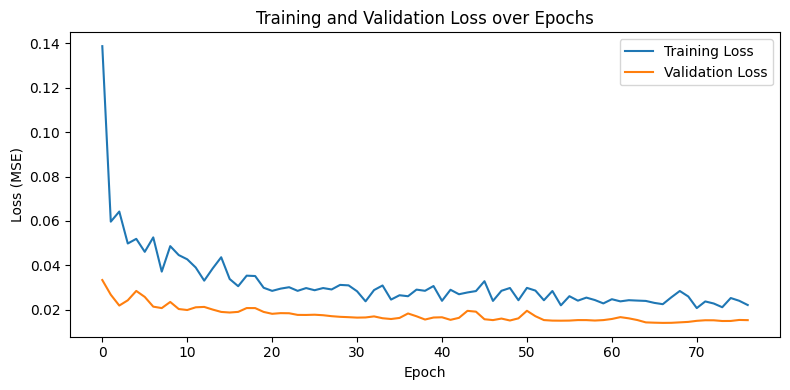

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'],     label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# -----------------------------------------------------------------------------
# 4. EVALUATE & INVERSE-SCALE PREDICTIONS
# -----------------------------------------------------------------------------
# predict
y_pred = model.predict(X_test)

# we need to inverse-scale only the target dimension
# so rebuild full array placeholders
y_test_full  = np.zeros((len(y_test), data.shape[1]))
y_pred_full  = np.zeros_like(y_test_full)
y_test_full[:, -1] = y_test
y_pred_full[:, -1] = y_pred.flatten()

inv_test = scaler.inverse_transform(y_test_full)[:,-1]
inv_pred = scaler.inverse_transform(y_pred_full)[:,-1]

# compute simple metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(inv_test, inv_pred))
mae  = mean_absolute_error(inv_test, inv_pred)
print(f"Test RMSE: {rmse:.3f}, MAE: {mae:.3f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Test RMSE: 10.739, MAE: 9.193


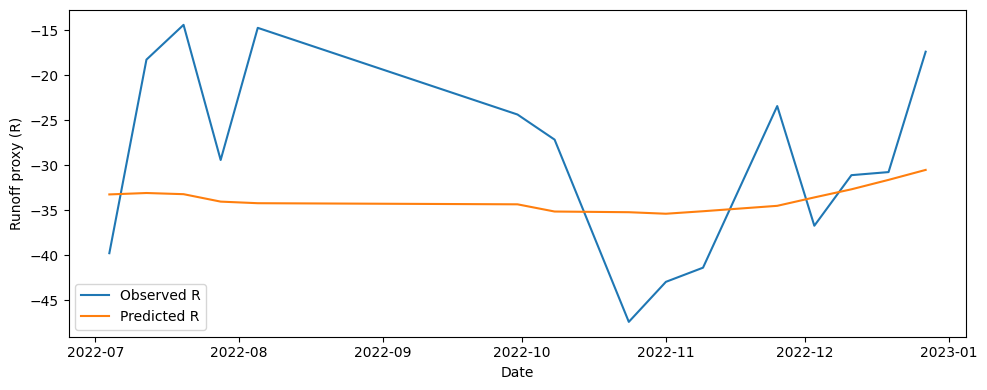

In [17]:
# -----------------------------------------------------------------------------
# 5. OPTIONAL: PLOT RESULTS
# -----------------------------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df['date'].values[-len(inv_test):], inv_test, label='Observed R')
plt.plot(df['date'].values[-len(inv_pred):], inv_pred, label='Predicted R')
plt.xlabel('Date'); plt.ylabel('Runoff proxy (R)');
plt.legend(); plt.tight_layout(); plt.show()